In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import time
from itertools import combinations, product
import copy
import functools
import random
import ast

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
def get_distance_matrix(df):
    coords = df[['x', 'y']].to_numpy()
    
    distance_matrix = np.round(squareform(pdist(coords, 'euclidean')))
    np.fill_diagonal(distance_matrix, 0)
    
    return distance_matrix


def random_search(distance_matrix):
    n = len(distance_matrix)
    
    solution = list(range(n))
    np.random.shuffle(solution)
    
    return solution[:(n//2)]


def get_total_cost(solution, distance_matrix, costs):
    assert len(solution) * 2 == len(distance_matrix)
    total_cost = 0
    
    for i in range(len(solution)-1):
        total_cost += distance_matrix[solution[i], solution[i+1]] + costs[solution[i+1]]
        
    total_cost += distance_matrix[solution[-1], solution[0]] + costs[solution[0]]
        
    return total_cost


In [3]:
def compute_inter_move_delta(solution, distance_matrix, costs, idx, new_node):
    n = len(solution)
    new_solution = solution.copy()
    old_node = solution[idx]

    new = (costs[new_node] +
            distance_matrix[new_solution[idx-1], new_node] +
            distance_matrix[new_node, new_solution[(idx+1)%n]])

    old = (costs[old_node] +
             distance_matrix[new_solution[idx-1], old_node] +
             distance_matrix[old_node, new_solution[(idx+1)%n]])

    delta = new - old
    new_solution[idx] = new_node

    return new_solution, delta



def compute_intra_move_delta(solution, distance_matrix, indices, backward=False):
    ## without roll/shift to initial form
    n = len(solution)
    i, j = indices
    
    if i >= j: raise Exception('Wrong indices, i >= j')
    if j >= n: raise Exception('Wrong indices, j >= n')
    
    if backward:
        if (i == 0 and j in (n-1, n-2)) or (j == n-1 and i in (0, 1)):
            return solution, 0
        new = distance_matrix[solution[i], solution[(j+1)%n]] + distance_matrix[solution[j], solution[i-1]]
        old = distance_matrix[solution[i-1], solution[i]] + distance_matrix[solution[j], solution[(j+1)%n]]
    else:
        if j - i in (1, 2):
            return solution, 0
        new = distance_matrix[solution[i], solution[j-1]] + distance_matrix[solution[i+1], solution[j]]
        old = distance_matrix[solution[i], solution[i+1]] + distance_matrix[solution[j-1], solution[j]]
        
    delta = new - old
    
    if backward:
        new_solution = solution[j+1:][::-1] + solution[i:j+1] + solution[:i][::-1]
    else:
        new_solution = solution[:i+1] + solution[i+1:j][::-1] + solution[j:]

    return new_solution, delta



def steepest_local_search(solution, distance_matrix, costs):
    solution = solution[:]
    n, N = len(solution), len(distance_matrix)
    solution_set = set(solution)
    outer_nodes_set = set(range(N)) - solution_set 
    
    while True:
        best_delta, best_solution = 0, None
        inter_move_flag, inter_move_outer_node, inter_move_inner_node_idx = False, None, None
        
        # inter
        for outer_node, inner_node_idx in product(outer_nodes_set, range(n)):
            new_solution, delta = compute_inter_move_delta(solution, distance_matrix, costs, inner_node_idx, outer_node)
            if delta < best_delta:
                best_delta = delta
                best_solution = new_solution[:]
                inter_move_flag = True
                inter_move_outer_node, inter_move_inner_node_idx = outer_node, inner_node_idx
                
        # intra
        for i, j in combinations(range(n), 2):
            # forward
            new_solution, delta = compute_intra_move_delta(solution, distance_matrix, (i, j), False)
            if delta < best_delta:
                best_delta = delta
                best_solution = new_solution[:]
                inter_move_flag = False
            # backward
            new_solution, delta = compute_intra_move_delta(solution, distance_matrix, (i, j), True)
            if delta < best_delta:
                best_delta = delta
                best_solution = new_solution[:]
                inter_move_flag = False
        
        if best_solution is not None:
            if inter_move_flag:
               solution_set.add(inter_move_outer_node) 
               solution_set.remove(solution[inter_move_inner_node_idx])
               outer_nodes_set.remove(inter_move_outer_node) 
               outer_nodes_set.add(solution[inter_move_inner_node_idx]) 
            solution = best_solution[:]             
            continue
        return solution

In [4]:
def greedy_2_regret_weighted(distance_matrix, partial_solution, costs, target_size, regret_weight=0.5):
    num_nodes = len(distance_matrix)
    to_visit = set(range(num_nodes)) - set(partial_solution)
    
    solution = partial_solution[:]

    while len(solution) < target_size:
        max_weighted_sum = float('-inf')
        best_node = None
        best_insertion_point = None

        for node in to_visit:
            insertion_costs = []
            for i in range(len(solution) - 1):
                cost = distance_matrix[solution[i]][node] + distance_matrix[node][solution[i+1]] - distance_matrix[solution[i]][solution[i+1]] + costs[node]
                insertion_costs.append((cost, i))

            insertion_costs.append((distance_matrix[solution[-1]][node] + distance_matrix[node][solution[0]] - distance_matrix[solution[-1]][solution[0]] + costs[node], len(solution) - 1))

            insertion_costs.sort(key=lambda x: x[0])

            weighted_sum = 0
            if len(insertion_costs) > 1:
                regret = insertion_costs[1][0] - insertion_costs[0][0]
                objective = -insertion_costs[0][0]
                weighted_sum = regret_weight * regret + (1 - regret_weight) * objective

            if weighted_sum > max_weighted_sum:
                max_weighted_sum = weighted_sum
                best_node = node
                best_insertion_point = insertion_costs[0][1]

        solution.insert(best_insertion_point + 1, best_node)
        to_visit.remove(best_node)

    return solution

In [5]:
def get_initial_population(pop_size, distance_matrix, costs):
    population = []
    for _ in range(pop_size):
        solution = random_search(distance_matrix)
        new_solution = steepest_local_search(solution, distance_matrix, costs)
        population.append(new_solution)
    return population

In [50]:
def operator_1(parent1, parent2):
    length = len(parent1)
    child = [None] * length

    edges1 = {tuple(sorted((parent1[i], parent1[(i + 1) % length]))) for i in range(length)}
    edges2 = {tuple(sorted((parent2[i], parent2[(i + 1) % length]))) for i in range(length)}
    common_edges = edges1.intersection(edges2)

    for i in range(length - 1):
        edge = tuple(sorted((parent1[i], parent1[i + 1])))
        if edge in common_edges:
            child[i] = parent1[i]
            child[i + 1] = parent1[i + 1]

    common_nodes = set(parent1) & set(parent2) - set(child)

    for node in common_nodes:
        for i in range(length):
            if child[i] is None:
                child[i] = node
                break

    remaining_nodes = [node for node in range(length * 2) if node not in child]
    random.shuffle(remaining_nodes)
    for i in range(length):
        if child[i] is None:
            child[i] = remaining_nodes.pop()

    return child

In [51]:
def operator_2(parent1, parent2, distance_matrix, costs):
    length = len(parent1)
    
    edges1 = {tuple(sorted((parent1[i], parent1[(i + 1) % length]))) for i in range(length)}
    edges2 = {tuple(sorted((parent2[i], parent2[(i + 1) % length]))) for i in range(length)}
    common_edges = edges1.intersection(edges2)

    modified_parent = []
    for i in range(length - 1):
        edge = tuple(sorted((parent1[i], parent1[i + 1])))
        if edge in common_edges:
            if not modified_parent or modified_parent[-1] != parent1[i]:
                modified_parent.append(parent1[i])
            modified_parent.append(parent1[i + 1])
            
    modified_parent = greedy_2_regret_weighted(distance_matrix, modified_parent, costs, length)

    return modified_parent

In [7]:
df = pd.read_csv('../data/TSPA.csv', names=['x', 'y', 'cost'], sep=';')
distance_matrix = get_distance_matrix(df)
costs = df.cost.to_numpy()

In [32]:
solution = random_search(distance_matrix)
get_total_cost(solution, distance_matrix, costs)

278756.0

In [30]:
solution1 = steepest_local_search(solution, distance_matrix, costs)
get_total_cost(solution1, distance_matrix, costs)

82083.0

In [33]:
solution2 = steepest_local_search(solution, distance_matrix, costs)
get_total_cost(solution2, distance_matrix, costs)

78368.0

In [55]:
solution3 = operator_1(solution1, solution2)
get_total_cost(solution3, distance_matrix, costs)

170212.0

In [2]:
best_solutions = {
    'Evol_oper1_LS': {
        '../data/TSPA.csv': [111, 14, 80, 95, 169, 8, 26, 92, 48, 106, 160, 11, 152, 130, 119, 109, 189, 75, 174, 177, 1, 41, 199, 192, 43, 77, 4, 114, 91, 121, 50, 149, 0, 19, 178, 164, 159, 143, 59, 147, 116, 27, 96, 185, 64, 20, 71, 61, 163, 74, 113, 195, 53, 62, 32, 180, 81, 154, 144, 141, 87, 79, 194, 21, 171, 108, 15, 117, 22, 55, 36, 132, 128, 145, 76, 161, 153, 88, 127, 186, 45, 167, 101, 99, 135, 51, 112, 66, 6, 172, 156, 98, 190, 72, 12, 94, 42, 89, 73, 31],
        '../data/TSPB.csv': [179, 121, 127, 24, 131, 103, 38, 101, 31, 197, 183, 34, 5, 2, 182, 163, 172, 95, 135, 198, 190, 19, 33, 29, 18, 16, 8, 63, 82, 115, 69, 53, 142, 130, 141, 148, 140, 174, 51, 70, 91, 156, 67, 158, 162, 150, 117, 196, 44, 71, 193, 119, 59, 166, 85, 114, 72, 58, 89, 129, 64, 159, 147, 181, 170, 189, 12, 107, 139, 52, 132, 185, 73, 61, 136, 79, 145, 157, 80, 153, 55, 88, 137, 37, 165, 36, 25, 134, 154, 112, 50, 99, 57, 0, 169, 66, 26, 92, 122, 143],
        '../data/TSPC.csv': [20, 71, 61, 163, 74, 113, 195, 53, 62, 32, 180, 81, 154, 102, 144, 141, 87, 79, 194, 21, 171, 108, 15, 117, 22, 55, 36, 132, 128, 145, 76, 161, 153, 88, 127, 186, 45, 167, 101, 99, 135, 51, 5, 112, 72, 190, 66, 6, 172, 156, 98, 94, 42, 89, 12, 73, 31, 95, 169, 8, 26, 92, 48, 106, 160, 11, 152, 130, 119, 109, 189, 75, 1, 177, 41, 137, 199, 192, 43, 77, 4, 114, 91, 121, 50, 149, 0, 69, 19, 178, 164, 159, 143, 59, 147, 116, 27, 96, 185, 64],
        '../data/TSPD.csv': [47, 170, 181, 147, 159, 64, 129, 89, 58, 171, 72, 114, 85, 166, 71, 44, 196, 117, 150, 162, 158, 67, 3, 156, 91, 70, 51, 174, 140, 148, 141, 130, 142, 53, 32, 113, 69, 115, 82, 63, 8, 16, 18, 29, 33, 19, 190, 198, 135, 169, 66, 26, 92, 122, 143, 179, 197, 183, 34, 31, 101, 38, 103, 131, 121, 127, 24, 50, 43, 99, 137, 37, 165, 123, 154, 134, 25, 36, 88, 55, 4, 153, 80, 157, 145, 79, 136, 61, 73, 185, 132, 52, 12, 107, 97, 139, 193, 119, 59, 189],
    },
    'Evol_oper1_noLS': {
        '../data/TSPA.csv': [121, 91, 114, 4, 77, 43, 199, 41, 1, 177, 174, 75, 189, 60, 167, 101, 99, 135, 134, 119, 109, 130, 152, 11, 160, 106, 48, 26, 8, 80, 14, 111, 31, 95, 169, 196, 51, 112, 73, 12, 94, 72, 190, 98, 66, 6, 141, 144, 87, 24, 45, 186, 127, 88, 153, 161, 76, 128, 132, 36, 55, 195, 22, 53, 117, 15, 108, 171, 21, 194, 79, 154, 81, 180, 32, 62, 155, 163, 74, 113, 181, 25, 61, 183, 71, 20, 64, 185, 27, 147, 96, 59, 143, 159, 164, 178, 19, 0, 149, 50],
        '../data/TSPB.csv': [80, 157, 145, 153, 55, 88, 137, 37, 165, 36, 25, 154, 112, 50, 131, 103, 38, 101, 121, 24, 127, 122, 143, 179, 197, 183, 34, 5, 2, 182, 163, 40, 115, 113, 32, 69, 82, 63, 8, 139, 107, 59, 119, 193, 71, 44, 162, 150, 117, 196, 192, 142, 130, 141, 148, 140, 174, 51, 70, 91, 156, 3, 67, 114, 85, 72, 171, 58, 89, 129, 64, 159, 147, 87, 181, 170, 189, 109, 12, 52, 132, 185, 73, 61, 136, 33, 29, 18, 16, 172, 95, 19, 190, 198, 135, 66, 169, 0, 99, 57],
        '../data/TSPC.csv': [73, 89, 42, 94, 12, 72, 190, 98, 156, 172, 6, 66, 112, 5, 51, 135, 99, 101, 167, 153, 88, 127, 186, 45, 24, 141, 87, 79, 194, 21, 157, 171, 108, 15, 117, 18, 22, 55, 195, 53, 62, 163, 74, 113, 61, 71, 20, 56, 64, 185, 96, 27, 116, 147, 59, 143, 159, 178, 164, 128, 118, 132, 36, 145, 76, 161, 91, 121, 50, 149, 0, 69, 19, 35, 43, 77, 114, 4, 192, 199, 177, 1, 75, 189, 109, 119, 130, 188, 152, 11, 106, 48, 92, 26, 8, 124, 80, 169, 95, 31],
        '../data/TSPD.csv': [198, 135, 169, 66, 99, 57, 80, 157, 153, 4, 55, 88, 137, 37, 165, 123, 194, 36, 25, 134, 154, 50, 24, 127, 121, 103, 38, 42, 101, 31, 179, 143, 122, 197, 183, 34, 5, 2, 182, 163, 172, 16, 14, 8, 63, 82, 115, 69, 113, 53, 13, 142, 130, 141, 148, 140, 188, 161, 174, 83, 51, 70, 91, 156, 3, 45, 67, 114, 72, 58, 89, 159, 64, 129, 85, 166, 162, 150, 117, 192, 196, 44, 71, 193, 119, 59, 97, 139, 107, 12, 52, 18, 132, 185, 73, 61, 136, 33, 19, 190],
    },
    'Evol_oper2_LS': {
        '../data/TSPA.csv': [64, 20, 71, 61, 113, 74, 163, 155, 62, 32, 180, 81, 154, 102, 144, 141, 87, 79, 194, 21, 171, 108, 15, 117, 53, 22, 195, 55, 36, 132, 128, 145, 76, 161, 91, 121, 114, 175, 153, 88, 127, 186, 45, 167, 101, 99, 135, 51, 112, 66, 6, 156, 98, 190, 72, 94, 12, 73, 31, 111, 14, 80, 124, 95, 169, 8, 26, 92, 48, 106, 160, 11, 152, 130, 119, 109, 189, 75, 1, 177, 41, 199, 150, 192, 4, 77, 43, 50, 149, 0, 19, 178, 164, 159, 143, 59, 147, 27, 96, 185],
        '../data/TSPB.csv': [127, 24, 50, 152, 112, 154, 134, 25, 36, 123, 165, 37, 137, 88, 55, 153, 80, 157, 145, 79, 136, 73, 185, 132, 52, 139, 107, 12, 189, 170, 181, 147, 159, 64, 129, 89, 58, 72, 114, 85, 166, 59, 119, 71, 44, 196, 117, 150, 162, 158, 67, 156, 91, 70, 51, 174, 140, 148, 141, 130, 142, 53, 69, 115, 82, 63, 8, 16, 18, 29, 33, 19, 190, 198, 135, 95, 172, 163, 182, 2, 5, 128, 66, 169, 0, 57, 99, 92, 122, 143, 179, 197, 183, 34, 31, 101, 38, 103, 131, 121],
        '../data/TSPC.csv': [31, 73, 112, 5, 51, 135, 196, 95, 169, 110, 8, 26, 92, 48, 106, 160, 11, 152, 130, 119, 109, 189, 75, 1, 177, 41, 199, 192, 43, 77, 4, 114, 91, 121, 50, 149, 0, 69, 19, 178, 164, 34, 159, 143, 59, 147, 27, 96, 185, 64, 20, 71, 61, 163, 74, 113, 195, 22, 55, 36, 132, 128, 145, 76, 161, 153, 88, 127, 186, 170, 21, 79, 194, 171, 108, 15, 117, 53, 62, 32, 180, 81, 154, 102, 144, 87, 141, 24, 6, 156, 172, 66, 98, 190, 72, 12, 94, 89, 42, 111],
        '../data/TSPD.csv': [63, 8, 14, 16, 172, 95, 19, 190, 198, 135, 169, 66, 128, 5, 34, 183, 197, 92, 122, 143, 179, 31, 101, 42, 38, 103, 131, 121, 127, 24, 50, 43, 99, 137, 37, 165, 123, 154, 134, 25, 36, 88, 55, 4, 153, 80, 157, 145, 79, 136, 61, 73, 185, 132, 18, 52, 12, 107, 109, 189, 170, 181, 147, 159, 64, 129, 89, 58, 171, 72, 114, 85, 166, 59, 119, 193, 71, 44, 196, 117, 150, 162, 158, 67, 3, 156, 91, 70, 51, 174, 140, 148, 141, 130, 142, 53, 113, 69, 115, 82],
    },
    'Evol_oper2_noLS': {
        '../data/TSPA.csv': [101, 167, 45, 186, 127, 88, 153, 161, 76, 145, 128, 132, 36, 55, 117, 15, 108, 171, 21, 194, 79, 87, 141, 144, 102, 154, 81, 180, 32, 62, 53, 22, 195, 163, 74, 113, 181, 61, 183, 71, 20, 64, 185, 96, 27, 116, 147, 59, 143, 159, 164, 178, 19, 0, 149, 50, 121, 91, 114, 4, 77, 43, 192, 199, 41, 177, 1, 75, 189, 109, 119, 130, 152, 11, 160, 106, 48, 92, 26, 8, 95, 169, 124, 80, 14, 111, 31, 73, 89, 94, 98, 156, 6, 66, 190, 72, 112, 51, 135, 99],
        '../data/TSPB.csv': [115, 82, 63, 8, 16, 52, 12, 107, 139, 193, 119, 59, 71, 44, 162, 150, 117, 196, 192, 21, 142, 130, 141, 148, 140, 174, 51, 70, 91, 156, 67, 114, 85, 72, 171, 58, 89, 129, 64, 159, 147, 181, 170, 189, 185, 132, 18, 29, 33, 73, 61, 136, 79, 145, 157, 80, 153, 55, 88, 137, 57, 99, 102, 37, 165, 123, 36, 25, 134, 154, 112, 94, 50, 24, 127, 121, 131, 103, 38, 101, 31, 179, 143, 122, 197, 183, 34, 5, 128, 66, 169, 135, 198, 190, 19, 95, 172, 163, 182, 2],
        '../data/TSPC.csv': [171, 108, 15, 117, 53, 22, 195, 55, 36, 132, 128, 145, 76, 161, 153, 88, 127, 186, 45, 167, 101, 99, 135, 51, 112, 66, 6, 156, 98, 190, 72, 94, 42, 89, 73, 95, 169, 31, 111, 14, 80, 124, 123, 8, 26, 92, 48, 106, 160, 11, 152, 130, 119, 109, 189, 75, 177, 1, 41, 199, 192, 77, 4, 114, 91, 121, 50, 149, 0, 19, 178, 164, 34, 159, 143, 59, 147, 27, 96, 185, 64, 20, 71, 61, 113, 74, 163, 155, 62, 32, 180, 81, 154, 102, 144, 141, 87, 79, 194, 21],
        '../data/TSPD.csv': [145, 157, 80, 153, 4, 55, 88, 36, 25, 134, 154, 123, 165, 37, 137, 99, 111, 92, 122, 143, 179, 121, 127, 24, 131, 103, 38, 42, 101, 31, 197, 183, 34, 5, 128, 66, 169, 135, 198, 190, 19, 95, 172, 16, 14, 8, 63, 82, 115, 69, 53, 142, 130, 141, 148, 140, 161, 174, 51, 70, 91, 156, 3, 78, 67, 158, 162, 150, 117, 196, 44, 71, 193, 119, 59, 166, 110, 114, 72, 171, 58, 89, 129, 64, 159, 147, 181, 170, 189, 109, 107, 12, 52, 18, 132, 185, 73, 61, 136, 79],
    }
}

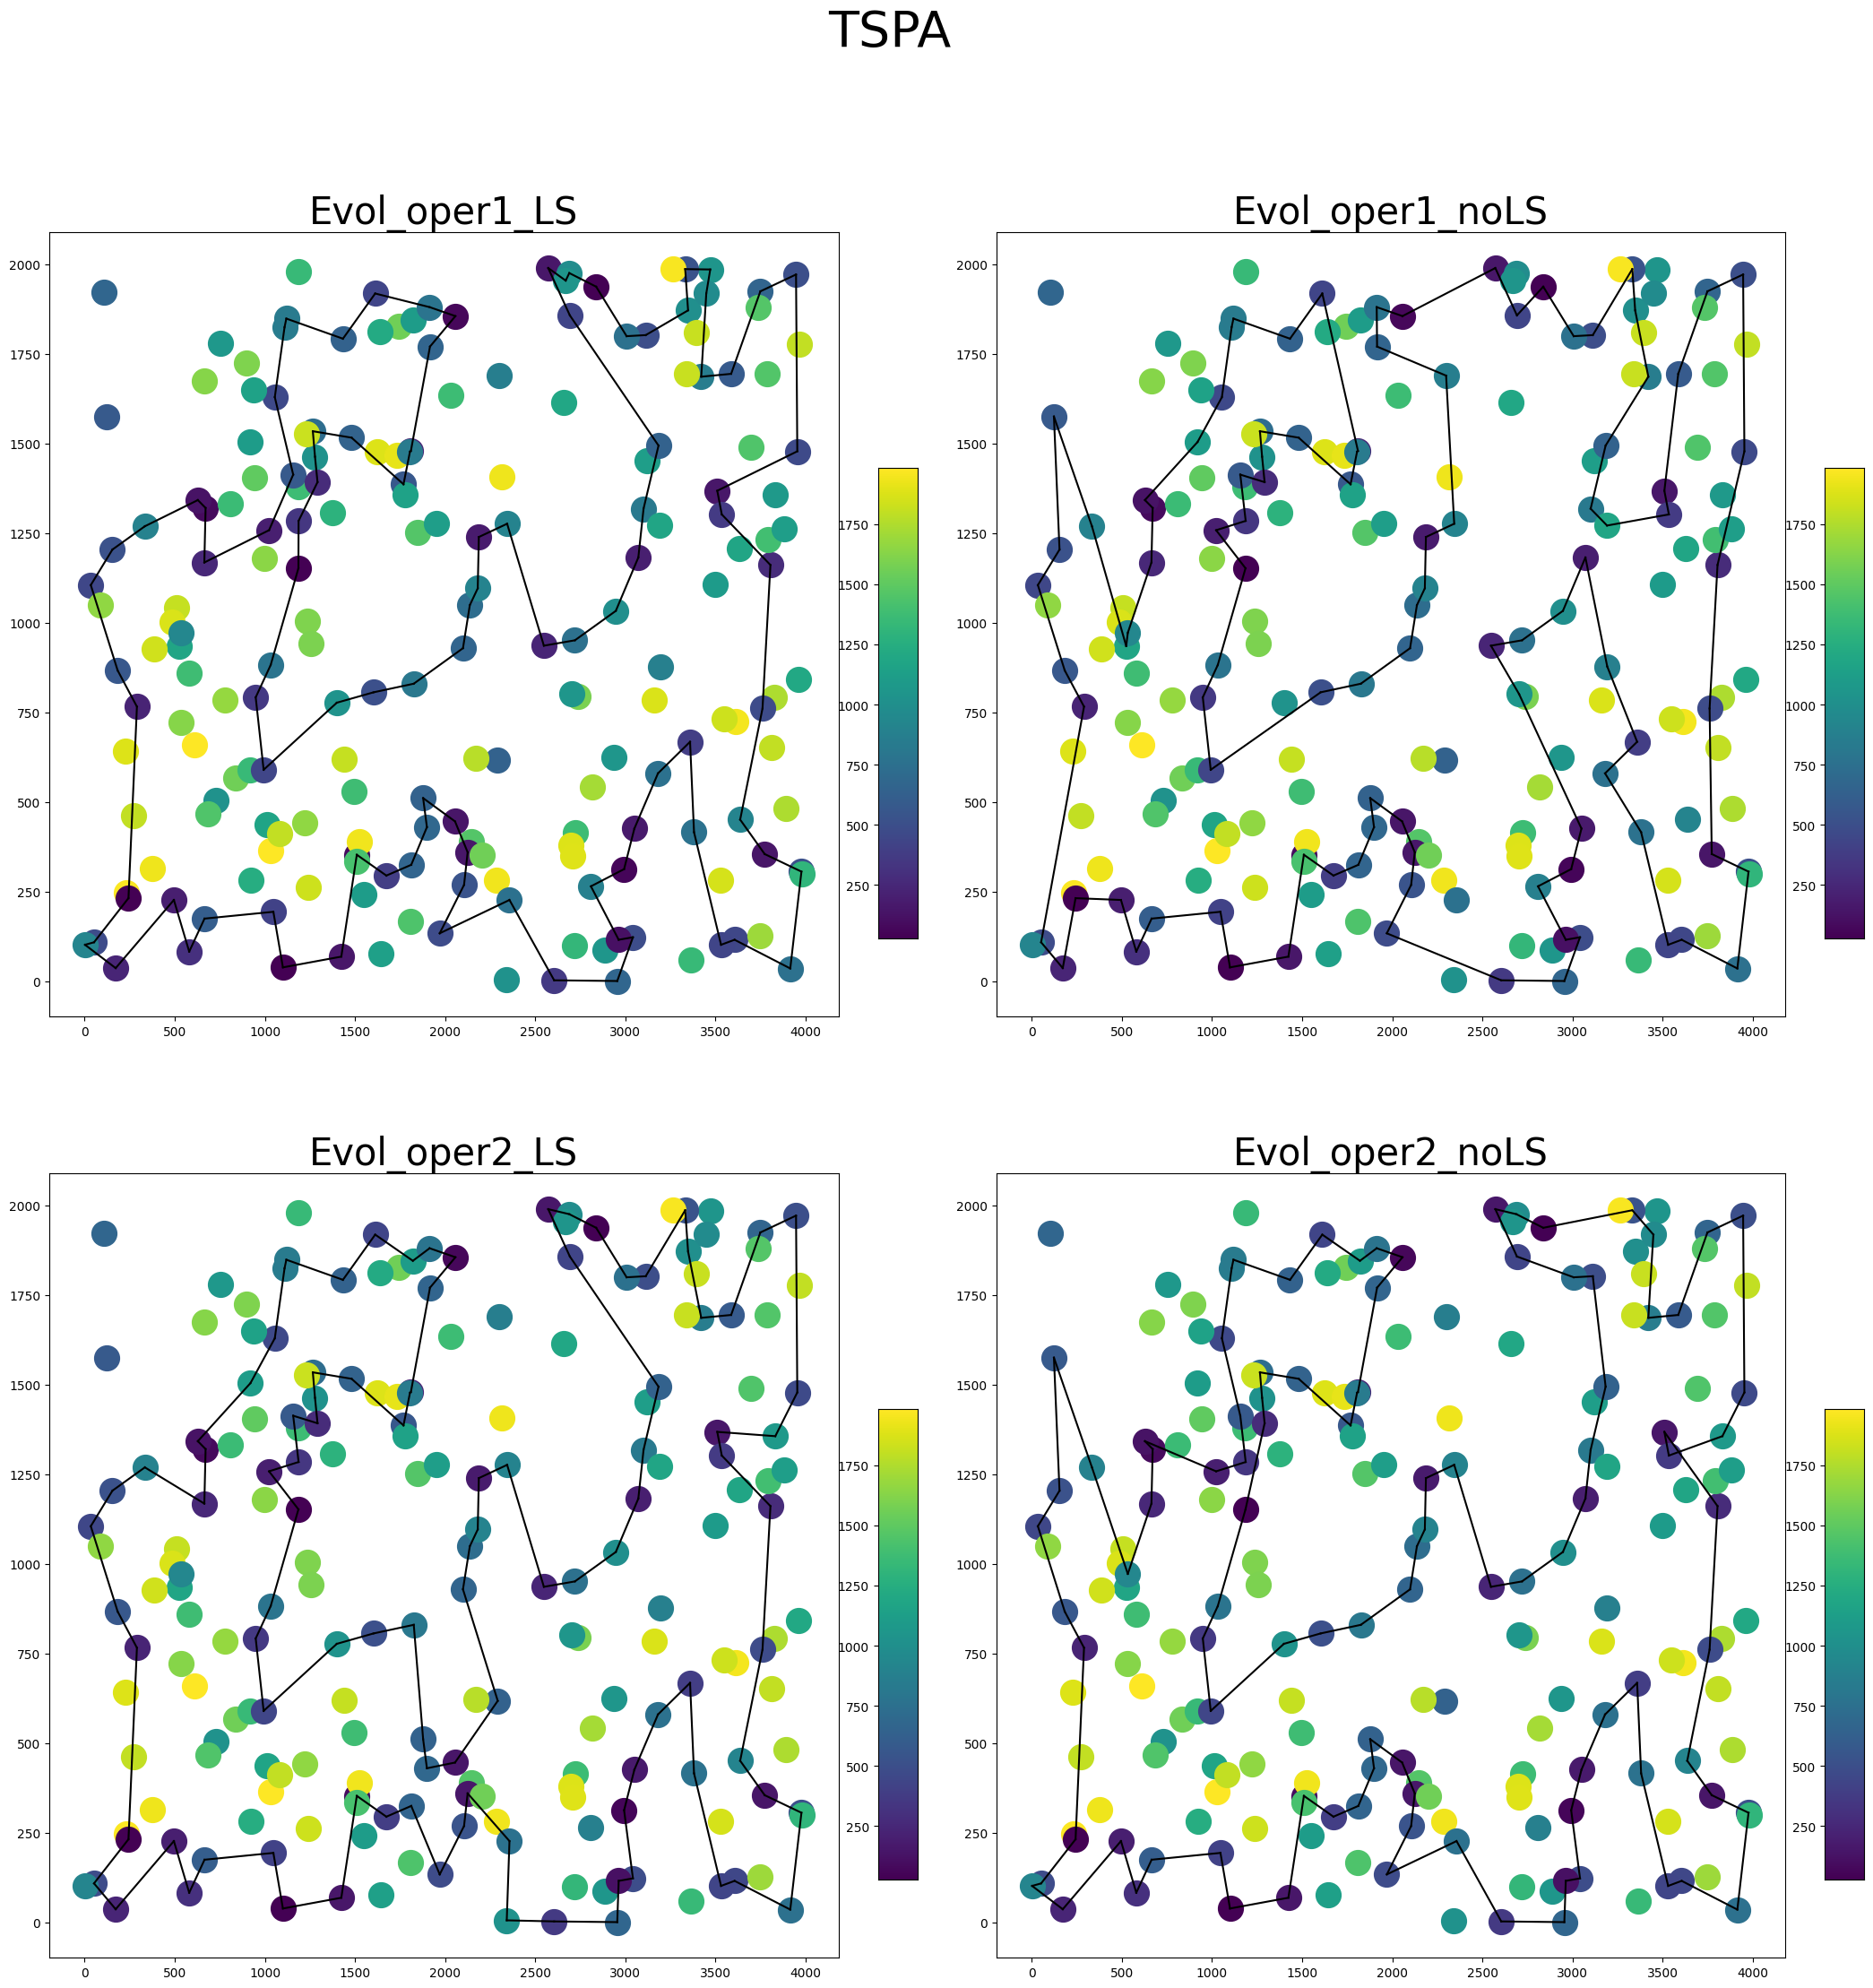

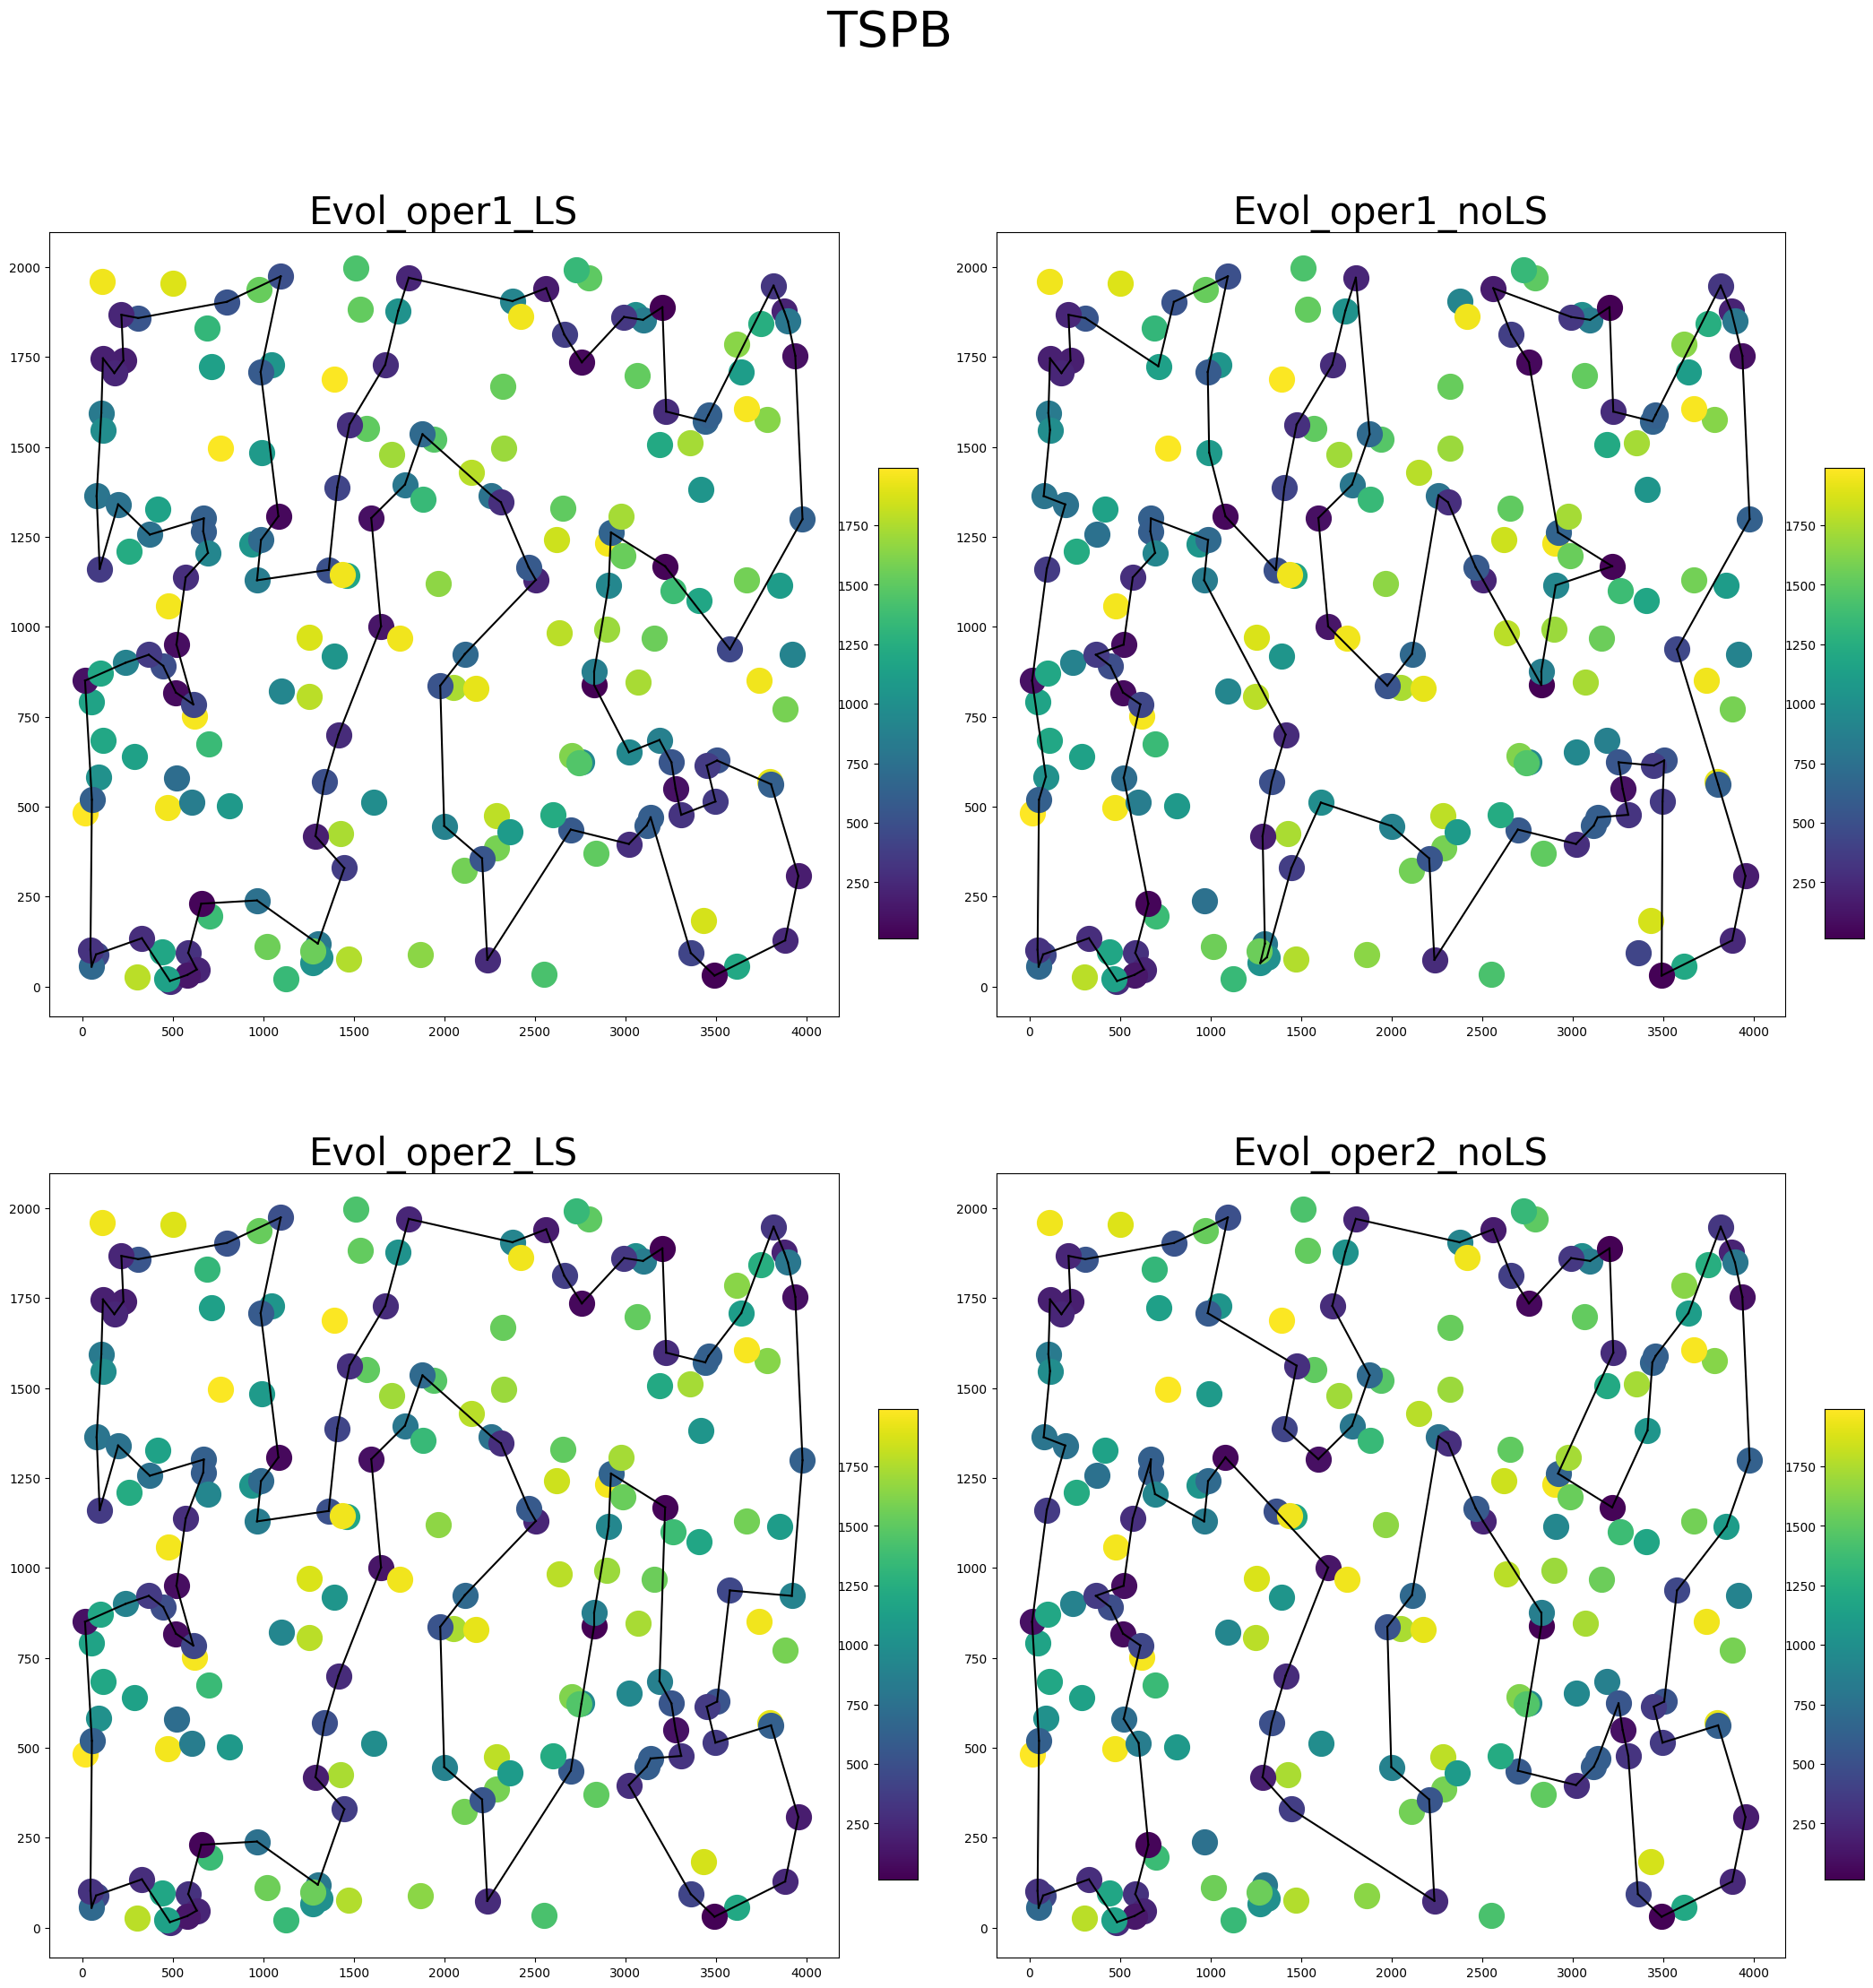

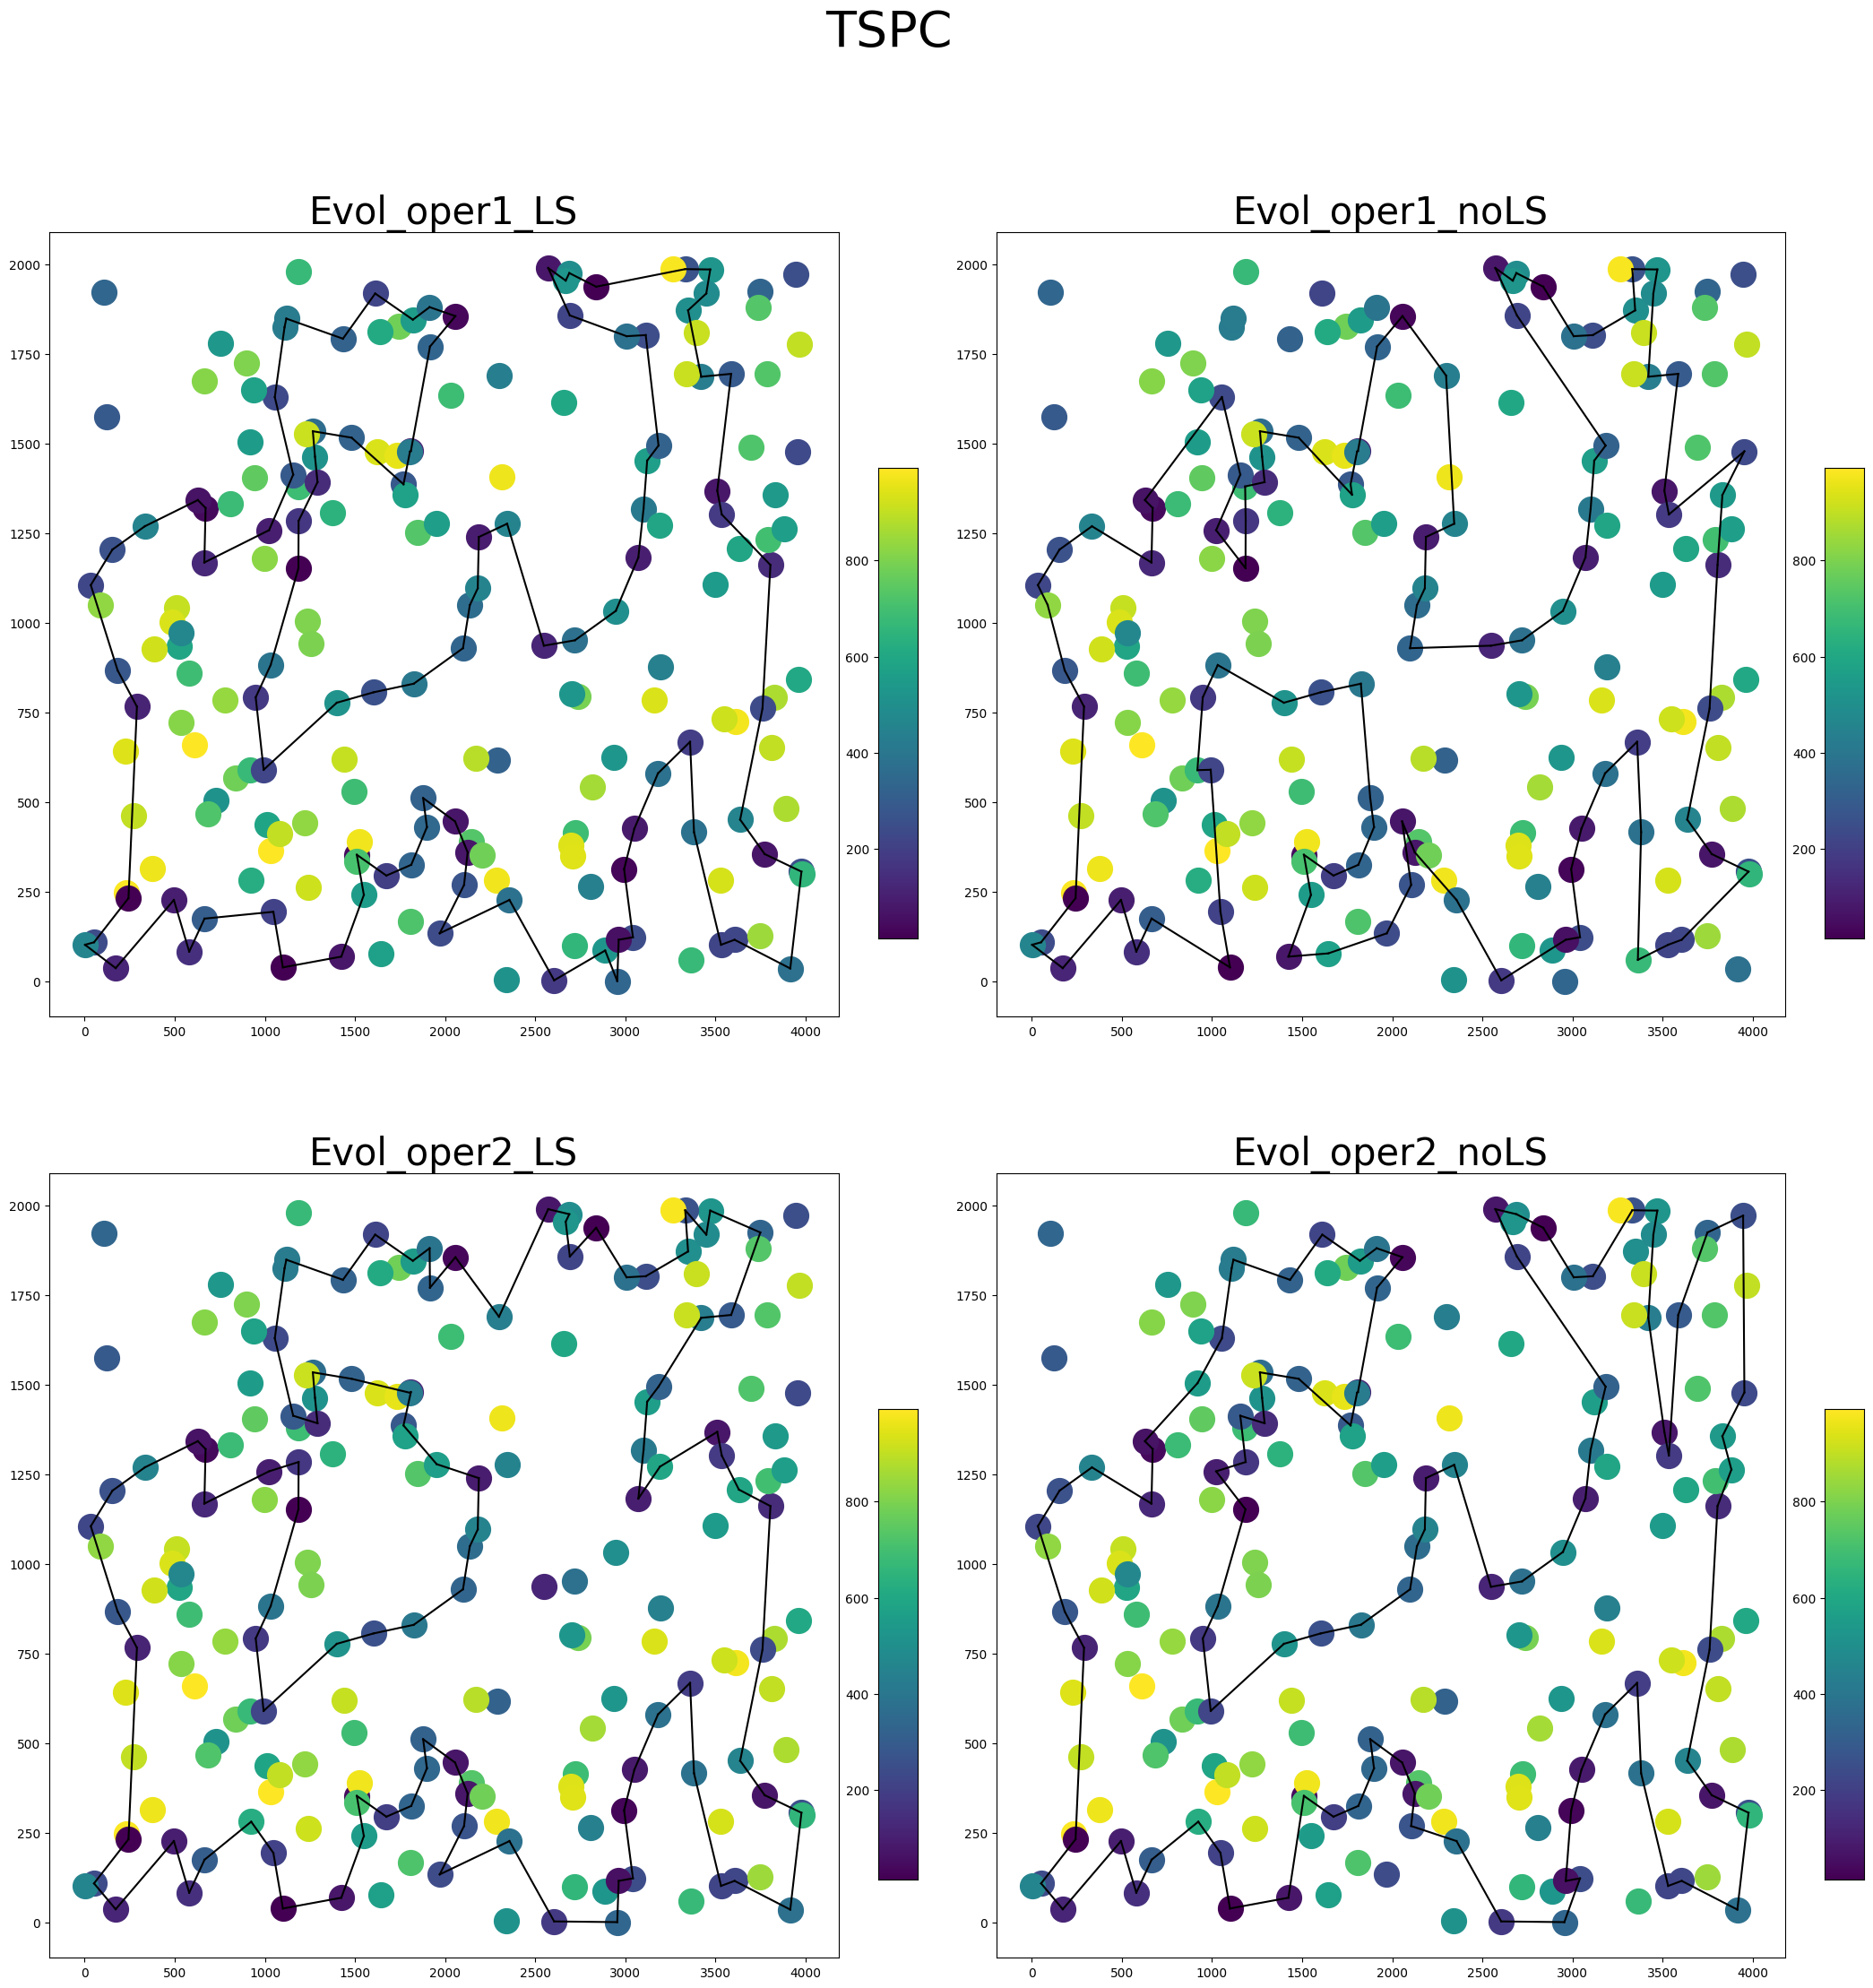

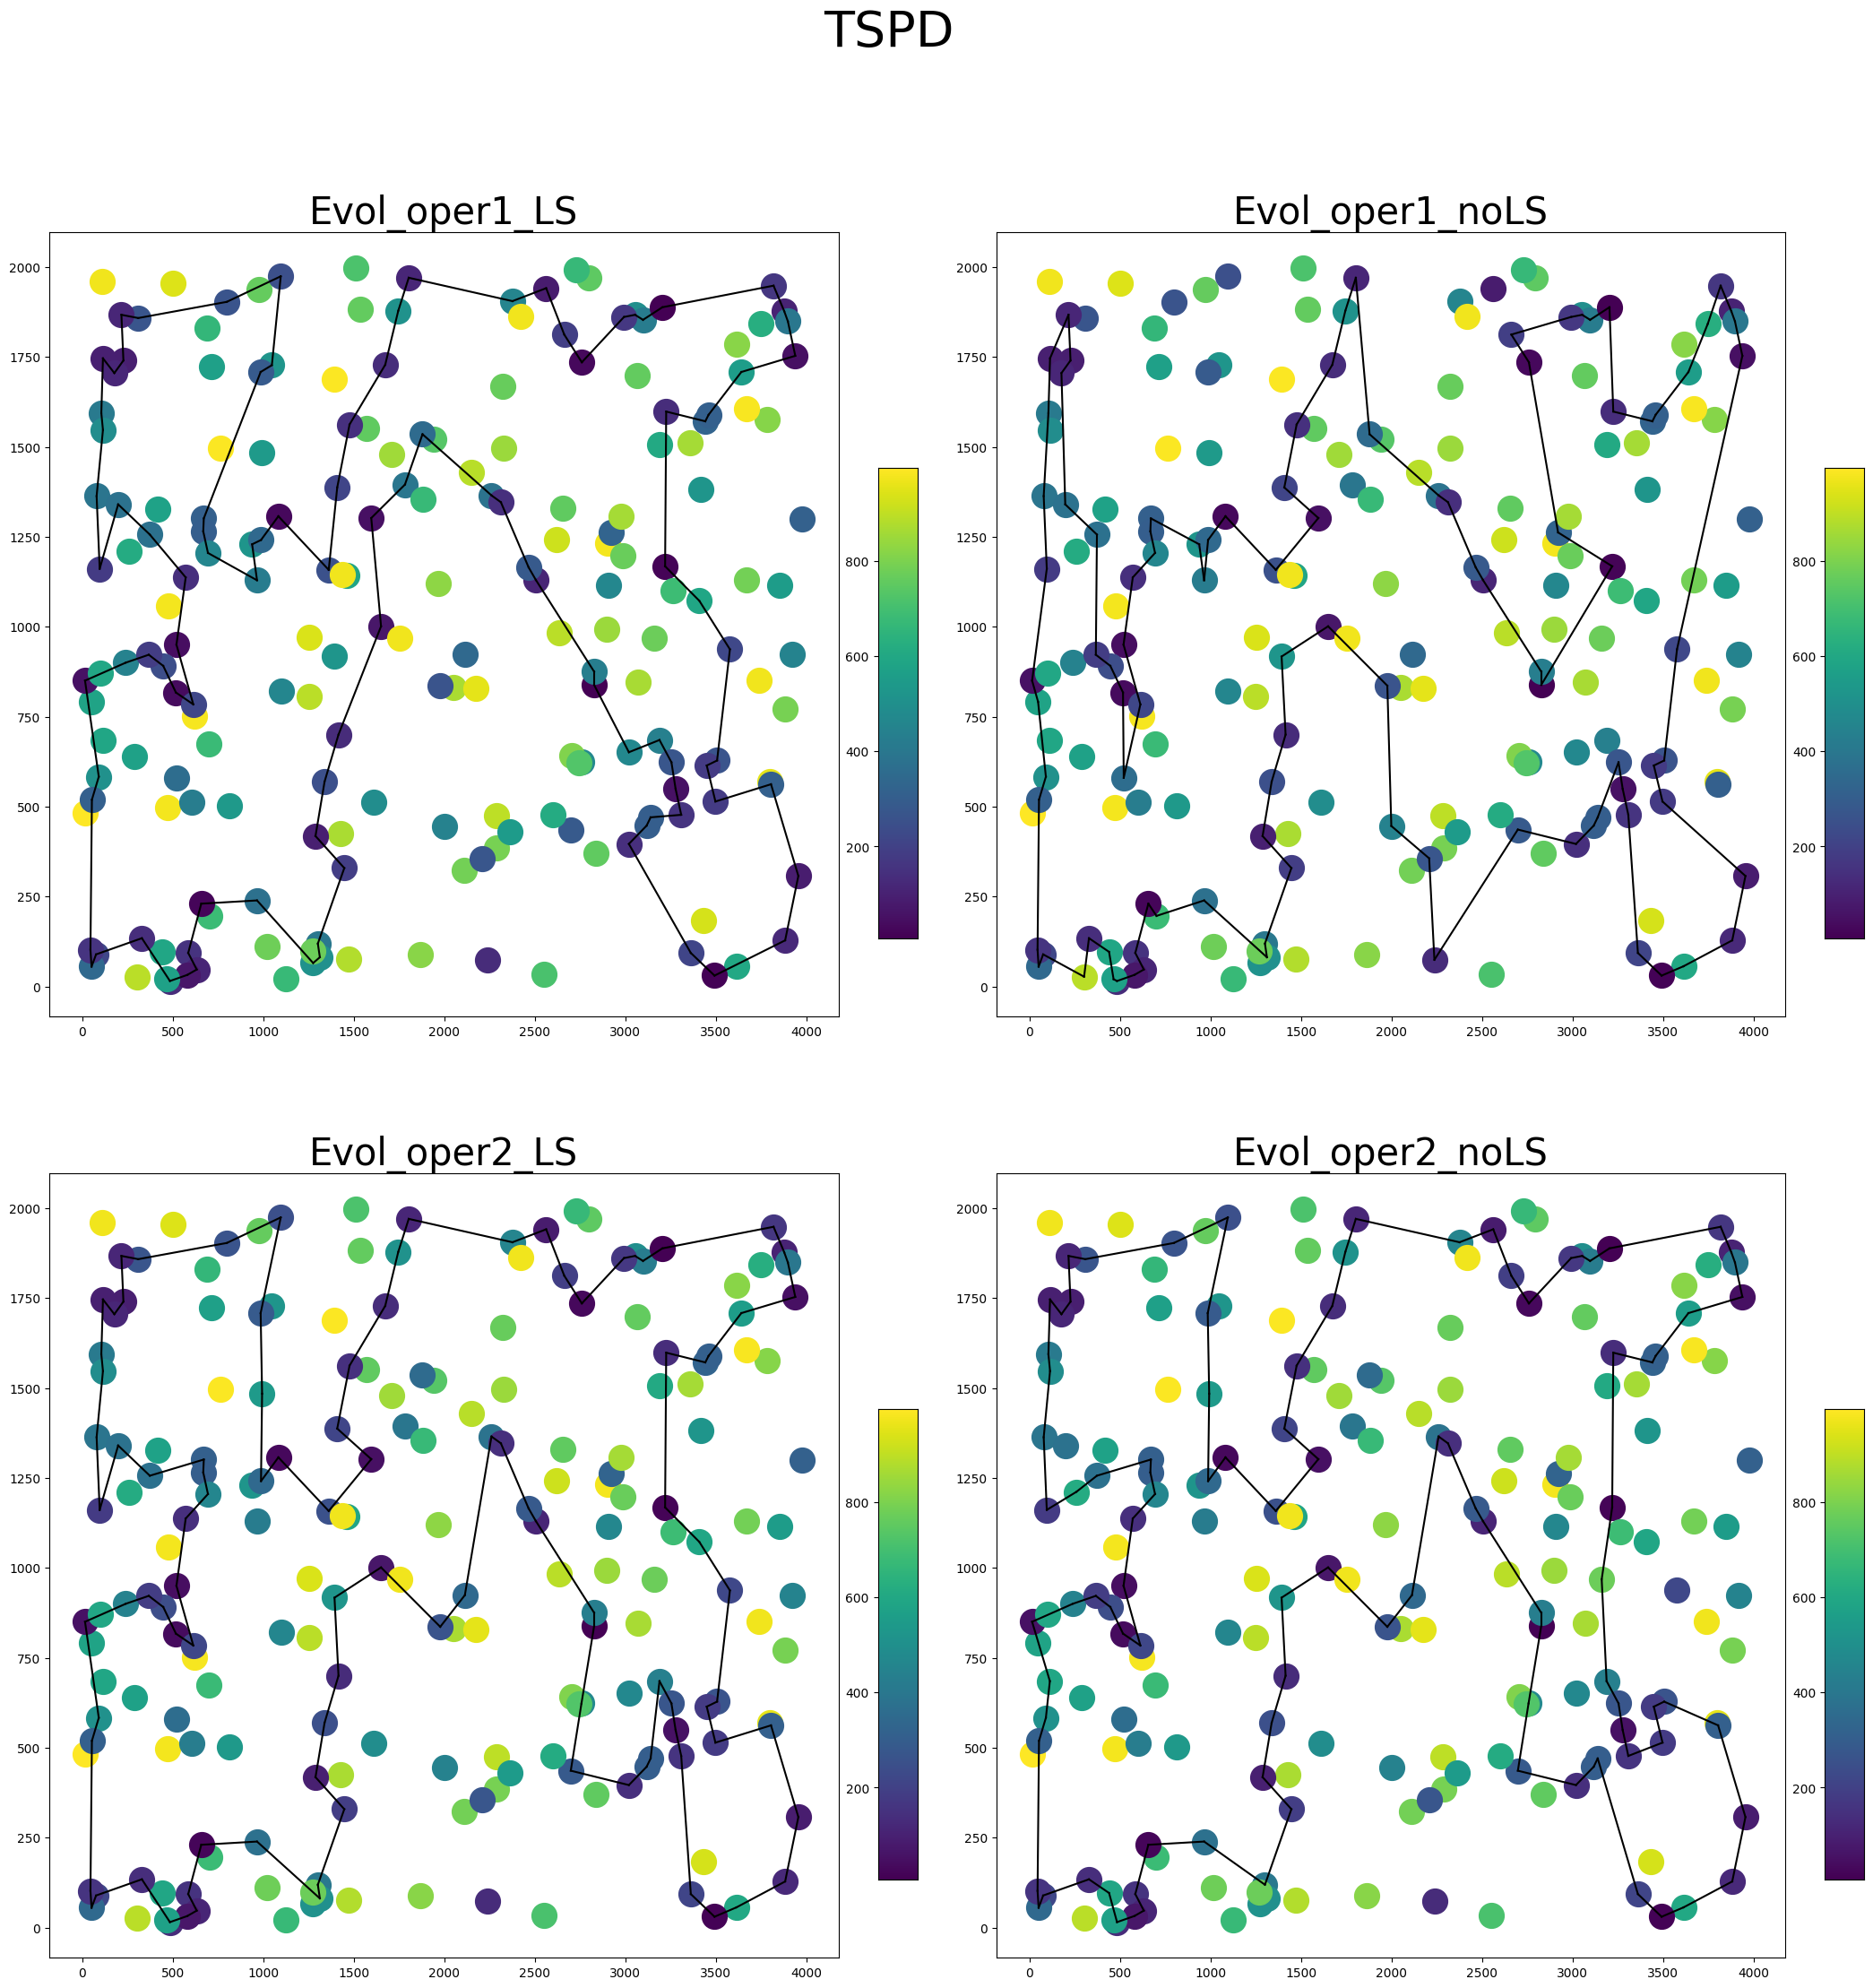

In [6]:
instances = ('../data/TSPA.csv', '../data/TSPB.csv', '../data/TSPC.csv', '../data/TSPD.csv')

for instance in instances:
    fig, ax = plt.subplots(2, 2, figsize=(25, 25))
    ax = ax.flatten()
    idx = 0
    fig.suptitle(instance.replace('../data/', '').replace('.csv', ''), fontsize=40)
    
    df = pd.read_csv(instance, names=['x', 'y', 'cost'], sep=';')
    weights = df['cost']
    cmap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
    
    for algo in best_solutions:
        solution = best_solutions[algo][instance]
        for i in range(len(df)):
            x, y, cost = df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['cost']
            ax[idx].plot(x, y, "o", markersize=20, color=cmap(norm(cost)))
        for i in range(len(solution)-1):
            x, y, cost = df.iloc[solution[i]]['x'], df.iloc[solution[i]]['y'], df.iloc[solution[i]]['cost']
            x_next, y_next = df.iloc[solution[i+1]]['x'], df.iloc[solution[i+1]]['y']
            ax[idx].plot((x, x_next), (y, y_next), "-", color='black')
        x, y = df.iloc[solution[0]]['x'], df.iloc[solution[0]]['y']
        ax[idx].plot((x, x_next), (y, y_next), "-", color='black')
        
        axins = ax[idx].inset_axes([1.05, 0.1, 0.05, 0.6], transform=ax[idx].transAxes)
        gradient = np.linspace(0, 1, 256).reshape(-1, 1)

        axins.imshow(gradient, aspect='auto', cmap=cmap, origin='lower', extent=[0, 1, min(weights), max(weights)])
        axins.xaxis.set_visible(False)
        
        ax[idx].set_title(algo, fontsize=30)
        
        idx += 1
        
    plt.savefig(f'''./plots/{instance.replace('../data/', '').replace('.csv', '')}.png''')
    plt.show()
    
    

# for algo in best_solutions:
#     fig, ax = plt.subplots(2, 2, figsize=(25, 25))
#     ax = ax.flatten()
#     idx = 0
#     fig.suptitle(algo, fontsize=40)
#     for instance in best_solutions[algo]:
#         solution = best_solutions[algo][instance]
#         df = pd.read_csv(instance, names=['x', 'y', 'cost'], sep=';')
#         weights = df['cost']
#         cmap = plt.cm.viridis
#         norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
#         ax[idx].set_title(instance.replace('../data/', '').replace('.csv', ''), fontsize=30)
#         for i in range(len(df)):
#             x, y, cost = df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['cost']
#             ax[idx].plot(x, y, "o", markersize=20, color=cmap(norm(cost)))
#         for i in range(len(solution)-1):
#             x, y, cost = df.iloc[solution[i]]['x'], df.iloc[solution[i]]['y'], df.iloc[solution[i]]['cost']
#             x_next, y_next = df.iloc[solution[i+1]]['x'], df.iloc[solution[i+1]]['y']
#             ax[idx].plot((x, x_next), (y, y_next), "-", color='black')
#         x, y = df.iloc[solution[0]]['x'], df.iloc[solution[0]]['y']
#         ax[idx].plot((x, x_next), (y, y_next), "-", color='black')
        
#         axins = ax[idx].inset_axes([1.05, 0.1, 0.05, 0.6], transform=ax[idx].transAxes)
#         gradient = np.linspace(0, 1, 256).reshape(-1, 1)

#         axins.imshow(gradient, aspect='auto', cmap=cmap, origin='lower', extent=[0, 1, min(weights), max(weights)])
#         axins.xaxis.set_visible(False)
        
#         idx += 1
        
#     # plt.savefig(f'./plots/{algo}.png')
#     plt.show()